In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# import os
# os.chdir("/content/drive/MyDrive/AML/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Shannon information and image classification**
##Mert Yildiz 1951070 
##Ali Reza Seifi Mojaddar 1900547
##Gianmarco Ursini 1635956
##Mohammadreza Mowlai 1917906

#Import packages

In [ ]:
from keras.datasets import cifar100
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd

from tensorflow import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, ReLU, MaxPool2D, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import trange
from keras.engine import training


#Download the data and convert the labels

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode="coarse")

In [ ]:
# Change the labels from categorical to one-hot encoding
y_onehot_train = to_categorical(y_train)
y_onehot_test = to_categorical(y_test)

#Compute red, green and blue pixel probability distributions

In [ ]:
def compute_probabilities(bin_size,x):
  #Initialize arrays to store pixels probability distributions
  red_pixels=np.ones(256//bin_size+1)
  green_pixels=np.ones(256//bin_size+1)
  blue_pixels=np.ones(256//bin_size+1)

  #Build the probability distributions
  for img in tqdm(x):
    for pixel in img[:,:,0].flatten():
      red_pixels[pixel//bin_size]+=1
    for pixel in img[:,:,1].flatten():
      green_pixels[pixel//bin_size]+=1
    for pixel in img[:,:,2].flatten():
      blue_pixels[pixel//bin_size]+=1  

  #The total number of pixel seen is 
  n_pixels=x.shape[0]*x.shape[1]*x.shape[2]*x.shape[3]

  #Normalize probabilities
  red_pixels_prob=red_pixels/n_pixels
  green_pixels_prob=green_pixels/n_pixels
  blue_pixels_prob=blue_pixels/n_pixels

  return(red_pixels_prob,green_pixels_prob,blue_pixels_prob)

In [ ]:
#Define bin size over which pixel values will be discretized
bin_size=1
red_pixels_prob,green_pixels_prob,blue_pixels_prob=compute_probabilities(bin_size,x_train)

100%|██████████| 50000/50000 [09:26<00:00, 88.22it/s]


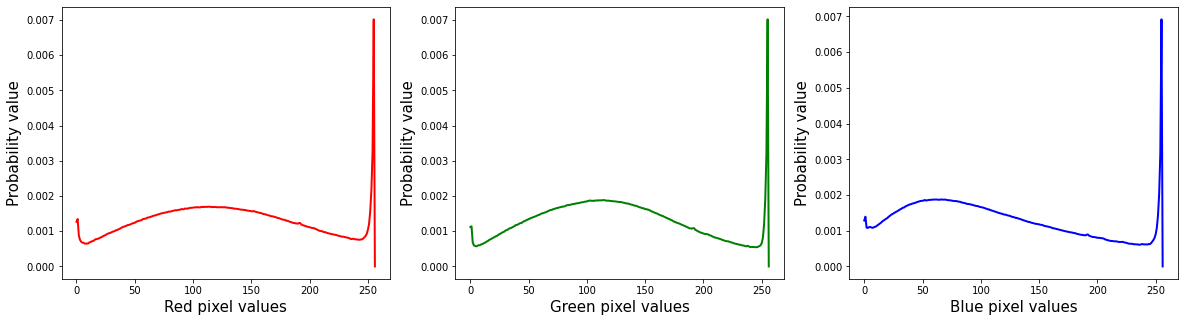

In [ ]:
# Plot pixel probability distributions
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(20,5))
ax1.plot(red_pixels_prob,color="red",linewidth=2)
ax1.set_xlabel("Red pixel values",fontsize=15)
ax1.set_ylabel("Probability value",fontsize=15)
ax2.plot(green_pixels_prob,color="green",linewidth=2)
ax2.set_xlabel("Green pixel values",fontsize=15)
ax2.set_ylabel("Probability value",fontsize=15)
ax3.plot(blue_pixels_prob,color="blue",linewidth=2)
ax3.set_xlabel("Blue pixel values",fontsize=15)
ax3.set_ylabel("Probability value",fontsize=15)
plt.show()

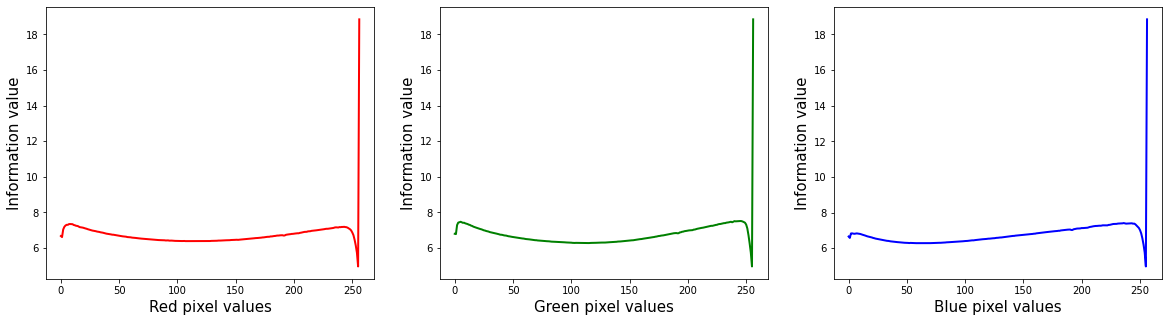

In [ ]:
#Plot information values 
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(20,5))
ax1.plot(-np.log(red_pixels_prob),color="red",linewidth=2)
ax1.set_xlabel("Red pixel values",fontsize=15)
ax1.set_ylabel("Information value",fontsize=15)
ax2.plot(-np.log(green_pixels_prob),color="green",linewidth=2)
ax2.set_xlabel("Green pixel values",fontsize=15)
ax2.set_ylabel("Information value",fontsize=15)
ax3.plot(-np.log(blue_pixels_prob),color="blue",linewidth=2)
ax3.set_xlabel("Blue pixel values",fontsize=15)
ax3.set_ylabel("Information value",fontsize=15)
plt.show()

#1° approach: Augment images with Shannon information layers 

In [ ]:
def augment_dataset(informations,x,binsize):
  
  #Define modified_dataset np array to store augmented data
  modified_dataset=np.zeros((x.shape[0],x.shape[1],x.shape[2],2*x.shape[3]))
  
  #Append information layers to dataset
  for i, img in enumerate(tqdm(x)):
    
    #Define an empty information tensor
    inf_layers=np.zeros((x.shape[1],x.shape[2],x.shape[3]))

    for color in range(x.shape[3]):
      for row in range(x.shape[1]):
        for column in range(x.shape[2]):
          pixel_value=img[row,column,color]
          inf_layers[row,column,color]=informations[pixel_value//binsize,color]

    img=np.concatenate((img/255,inf_layers),axis=-1)
    modified_dataset[i]=img

  return(modified_dataset)

In [ ]:
#Reshape probabilities arrays in order to build a general tensor
red_pixels_prob=red_pixels_prob.reshape(len(red_pixels_prob), 1)
green_pixels_prob=green_pixels_prob.reshape(len(green_pixels_prob), 1)
blue_pixels_prob=blue_pixels_prob.reshape(len(blue_pixels_prob), 1)

#Concatenate all probabilities into a single tensor 
probs=np.concatenate((red_pixels_prob,green_pixels_prob,blue_pixels_prob),axis=1)

#Compute informations and normalize them in the interval 0-1
infos=-np.log(probs)
infos=infos/np.max(infos)

#Concatenate train and test images: both has to be augmented with 
#the probabilities computed only over the training set

x=np.concatenate((x_train, x_test), axis=0)

modified_dataset=augment_dataset(infos,x,bin_size)

100%|██████████| 60000/60000 [10:31<00:00, 95.04it/s]


In [ ]:
# # Store/Load modified dataset
# np.save("modified_dataset.npy", modified_dataset)
# modified_dataset = np.load("modified_dataset.npy")


#Split back the dataset into training and test subsets
x_train_augmented=modified_dataset[:x_train.shape[0]]
x_test_augmented=modified_dataset[x_train.shape[0]:]

#2° approach: modding of the onehot labels to let them contain Shannon informations

In [ ]:
#Define empy object to contain all the labels in the train set
modded_y=np.zeros((y_onehot_train.shape[0],21))

#Append to those label the sum of informations
for i in range(y_onehot_train.shape[0]):
  modded_y[i]=np.append(y_onehot_train[i],np.mean(x_train_augmented[i][:,:,3:]))

In [ ]:
#Since the true labels now contains one extra eelemnt, we need to rewrite our custom 
#loss and custom function to be used by the model to compute the accuracy

def own_loss(Lambda=0.1): 

  def custom_loss(y_mod, y_pred):
    #Extract true one hot labels 
    y_true=y_mod[:,:20]

    #Compute normalcategorical crossentropy
    normal_loss=tf.keras.losses.CategoricalCrossentropy()
    therm1=normal_loss(y_true,y_pred)
    
    #Compute regularization therm
    y_pred=tf.math.round(y_pred)
    diff=tf.math.square(y_true-y_pred)
    differences = tf.reduce_sum(diff, axis=1)/2
    reg_therms=y_mod[:,-1]
    therm2=tf.reduce_sum(differences*reg_therms)/(tf.keras.backend.int_shape(y_true)[0])*Lambda

    #Return both therms
    return therm1+therm2

  return custom_loss


def accuracy(y_mod,y_pred):
  y_true=y_mod[:,:20]

  return tf.keras.backend.mean(tf.keras.backend.equal(tf.keras.backend.argmax(y_true, axis=-1),tf.keras.backend.argmax(y_pred, axis=-1)))

#Define functions to create model and fit it

In [ ]:
from keras.backend import shape
def create_fit_model(batch_size,epochs,num_classes,train_data,train_label,l2,dropout_plevel,loss_function,metric_function,train_verbosity,stopping_patience):

  X_train,valid_X,train_label,valid_label = train_test_split(train_data, train_label, test_size=0.2, random_state=13)
  
  #Define shape of input
  shape_of_input=train_data[0].shape
  
  #Define model
  conv_net = Sequential()

  #1 convolutional block
  conv_net.add(Conv2D(128, kernel_size=(3, 3),strides=(1, 1),input_shape=shape_of_input,activation="linear",padding='same',kernel_regularizer=tf.keras.regularizers.l2(l2)))
  conv_net.add(MCDropout(dropout_plevel))
  conv_net.add(MaxPooling2D((2, 2),padding='valid'))
  conv_net.add(ReLU())

  #2 convolutional block
  conv_net.add(Conv2D(512, (3, 3),strides=(1, 1), activation='linear',padding='same',kernel_regularizer=tf.keras.regularizers.l2(l2)))
  conv_net.add(MCDropout(dropout_plevel))
  conv_net.add(MaxPooling2D((2, 2),padding='valid'))
  conv_net.add(ReLU())

  #3 convolutional block
  conv_net.add(Conv2D(512, (3, 3),strides=(1, 1), activation='linear',padding='same',kernel_regularizer=tf.keras.regularizers.l2(l2)))
  conv_net.add(MCDropout(dropout_plevel))
  conv_net.add(MaxPooling2D((2, 2),padding='valid'))
  conv_net.add(ReLU())

  #4 convolutional block
  conv_net.add(Conv2D(512, (3, 3),strides=(1, 1), activation='linear',padding='same',kernel_regularizer=tf.keras.regularizers.l2(l2)))
  conv_net.add(MCDropout(dropout_plevel))
  conv_net.add(MaxPooling2D((2, 2),padding='valid'))
  conv_net.add(ReLU())

  #5 convolutional block
  conv_net.add(Conv2D(512, (3, 3),strides=(1, 1), activation='linear',padding='same',kernel_regularizer=tf.keras.regularizers.l2(l2)))
  conv_net.add(MCDropout(dropout_plevel))
  conv_net.add(MaxPooling2D((2, 2),padding='valid'))
  conv_net.add(ReLU())

  #Dense classifier
  conv_net.add(Flatten())
  conv_net.add(Dense(512, activation='linear',kernel_regularizer=tf.keras.regularizers.l2(l2)))
  conv_net.add(MCDropout(dropout_plevel))
  conv_net.add(ReLU())
  conv_net.add(Dense(20, activation='softmax'))


  #Compile and train model
  earlyStopping = EarlyStopping(monitor='val_loss', patience=stopping_patience, verbose=0, mode='min')
  mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
  conv_net.compile(loss=loss_function, optimizer=keras.optimizers.Adam(),metrics=[metric_function])
  conv_train = conv_net.fit(X_train, train_label,batch_size=batch_size,epochs=epochs,verbose=train_verbosity,validation_data=(valid_X, valid_label), callbacks=[earlyStopping, mcp_save])

  return(conv_net,conv_train)

In [ ]:
class MCDropout(keras.layers.Dropout):
  def call(self, inputs):
    return super().call(inputs, training=True)


def get_predictions_with_uncertainty(model, X):
    
    predictions = []
    for i in range(10): # can be made more efficient by just forward passing several times through the last layer
        predictions.append(model.predict(X))
    predictions = np.array(predictions)
    
    means = np.mean(predictions, axis=0)
    std = np.std(predictions, axis=0)
    preds = np.argmax(means, axis=1)
    preds_std = np.array([std[i, preds[i]] for i in range(len(preds))])

    return preds, preds_std

#Define functions to print test results and plots

In [ ]:
def predicts_with_model(conv_net,x_test,y_test,dropout_plevel):
  onehot_test_predictions = conv_net.predict(x_test,verbose=0)
  test_predictions=np.array([np.argmax(el) for el in onehot_test_predictions])
  print("Accuracy over the test with normal dropout (P value: ",dropout_plevel,") set is: ",sum(test_predictions==y_test[:,0])/len(y_test))


  preds, stds = get_predictions_with_uncertainty(model=conv_net, X=x_test)
  labels = y_test[:,0] #np.argmax(y_test, axis=1)

  print('Accuracy over test set with MC dropout (P value: ',dropout_plevel,') set is: ' + str((preds == labels).sum()/len(labels)))

  misclassified_mask = labels != preds

  print('Average standard deviation of classification: ' + str(np.mean(stds)))
  print('Average standard deviation of misclassified samples: ' + str(np.mean(stds[misclassified_mask])))

def plot_loss(conv_train):
  accuracy = conv_train.history['accuracy']
  val_accuracy = conv_train.history['val_accuracy']
  loss = conv_train.history['loss']
  val_loss = conv_train.history['val_loss']
  epochs = range(len(accuracy))
  plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
  plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

#Without Dropout...

##Implement model over normal images without dropout without regularization

In [ ]:
conv_net,conv_train=create_fit_model(batch_size=200,epochs=50,num_classes=20,train_data=x_train/255,
                                     train_label=y_onehot_train,l2=0,dropout_plevel=0,
                                     loss_function=tf.keras.losses.CategoricalCrossentropy(),metric_function="accuracy",
                                     train_verbosity=1,stopping_patience=5)

Epoch 1/50
200/200 [==============================] - 31s 150ms/step - loss: 2.6278 - accuracy: 0.1727 - val_loss: 2.3779 - val_accuracy: 0.2569
Epoch 2/50
200/200 [==============================] - 29s 147ms/step - loss: 2.1734 - accuracy: 0.3243 - val_loss: 2.0023 - val_accuracy: 0.3655
Epoch 3/50
200/200 [==============================] - 29s 147ms/step - loss: 1.9067 - accuracy: 0.4016 - val_loss: 1.8339 - val_accuracy: 0.4247
Epoch 4/50
200/200 [==============================] - 29s 147ms/step - loss: 1.7075 - accuracy: 0.4627 - val_loss: 1.7877 - val_accuracy: 0.4530
Epoch 5/50
200/200 [==============================] - 30s 149ms/step - loss: 1.5118 - accuracy: 0.5232 - val_loss: 1.6746 - val_accuracy: 0.4790
Epoch 6/50
200/200 [==============================] - 29s 146ms/step - loss: 1.3147 - accuracy: 0.5813 - val_loss: 1.6532 - val_accuracy: 0.5023
Epoch 7/50
200/200 [==============================] - 29s 147ms/step - loss: 1.1340 - accuracy: 0.6340 - val_loss: 1.6393 - val_ac

In [ ]:
predicts_with_model(conv_net,x_test/255,y_test,dropout_plevel=0)

Accuracy over the test with normal dropout (P value:  0 ) set is:  0.5234
Accuracy over test set with MC dropout (P value:  0 ) set is: 0.5234
Average standard deviation of classification: 3.7516653e-08
Average standard deviation of misclassified samples: 3.768124e-08


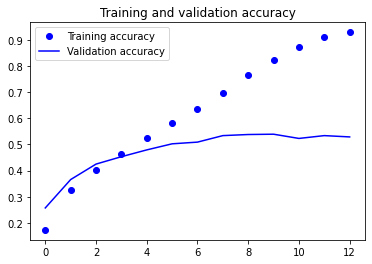

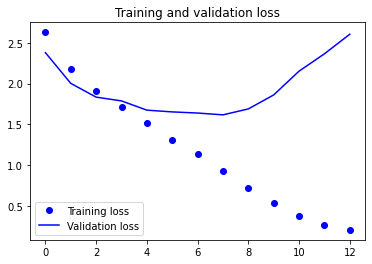

In [ ]:
plot_loss(conv_train)

##Implement model over augmented images without dropout without regularization

In [ ]:
conv_net,conv_train=create_fit_model(batch_size=200,epochs=50,num_classes=20,train_data=x_train_augmented,
                                     train_label=y_onehot_train,l2=0,dropout_plevel=0,
                                     loss_function=tf.keras.losses.CategoricalCrossentropy(),metric_function="accuracy",
                                     train_verbosity=1,stopping_patience=5)

Epoch 1/50
200/200 [==============================] - 44s 158ms/step - loss: 2.6986 - accuracy: 0.1473 - val_loss: 2.4331 - val_accuracy: 0.2299
Epoch 2/50
200/200 [==============================] - 30s 148ms/step - loss: 2.2942 - accuracy: 0.2839 - val_loss: 2.1197 - val_accuracy: 0.3387
Epoch 3/50
200/200 [==============================] - 29s 146ms/step - loss: 2.0344 - accuracy: 0.3613 - val_loss: 2.0527 - val_accuracy: 0.3661
Epoch 4/50
200/200 [==============================] - 30s 151ms/step - loss: 1.8419 - accuracy: 0.4198 - val_loss: 1.8061 - val_accuracy: 0.4264
Epoch 5/50
200/200 [==============================] - 29s 147ms/step - loss: 1.6767 - accuracy: 0.4705 - val_loss: 1.7110 - val_accuracy: 0.4620
Epoch 6/50
200/200 [==============================] - 29s 145ms/step - loss: 1.5074 - accuracy: 0.5223 - val_loss: 1.6725 - val_accuracy: 0.4751
Epoch 7/50
200/200 [==============================] - 29s 147ms/step - loss: 1.3218 - accuracy: 0.5780 - val_loss: 1.6500 - val_ac

In [ ]:
predicts_with_model(conv_net,x_test_augmented,y_test,dropout_plevel=0)

Accuracy over the test with normal dropout (P value:  0 ) set is:  0.5032
Accuracy over test set with MC dropout (P value:  0 ) set is: 0.5032
Average standard deviation of classification: 3.7267803e-08
Average standard deviation of misclassified samples: 3.543525e-08


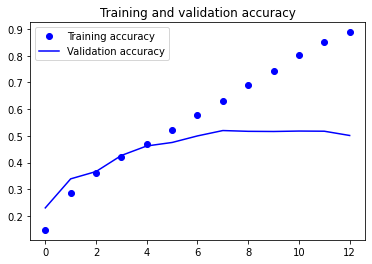

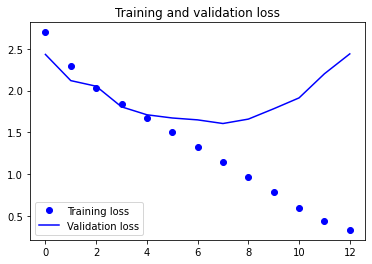

In [ ]:
plot_loss(conv_train)

##Implement model over original images without dropout with own regularization 

In [ ]:
conv_net,conv_train=create_fit_model(batch_size=200,epochs=50,num_classes=20,train_data=x_train/255,
                                     train_label=modded_y,l2=0,dropout_plevel=0,
                                     loss_function=own_loss(Lambda=0.01),metric_function=accuracy,
                                     train_verbosity=1,stopping_patience=5)

Epoch 1/50
200/200 [==============================] - 32s 153ms/step - loss: 2.6091 - accuracy: 0.1802 - val_loss: 2.3083 - val_accuracy: 0.2754
Epoch 2/50
200/200 [==============================] - 29s 147ms/step - loss: 2.1283 - accuracy: 0.3348 - val_loss: 2.0176 - val_accuracy: 0.3691
Epoch 3/50
200/200 [==============================] - 30s 150ms/step - loss: 1.8633 - accuracy: 0.4177 - val_loss: 1.8132 - val_accuracy: 0.4275
Epoch 4/50
200/200 [==============================] - 29s 146ms/step - loss: 1.6358 - accuracy: 0.4839 - val_loss: 1.6619 - val_accuracy: 0.4751
Epoch 5/50
200/200 [==============================] - 29s 148ms/step - loss: 1.4224 - accuracy: 0.5483 - val_loss: 1.5572 - val_accuracy: 0.5153
Epoch 6/50
200/200 [==============================] - 30s 148ms/step - loss: 1.2325 - accuracy: 0.6052 - val_loss: 1.5293 - val_accuracy: 0.5303
Epoch 7/50
200/200 [==============================] - 28s 138ms/step - loss: 1.0191 - accuracy: 0.6722 - val_loss: 1.5552 - val_ac

In [ ]:
predicts_with_model(conv_net,x_test/255,y_test,dropout_plevel=0)

Accuracy over the test with normal dropout (P value:  0 ) set is:  0.5458
Accuracy over test set with MC dropout (P value:  0 ) set is: 0.5458
Average standard deviation of classification: 3.7550926e-08
Average standard deviation of misclassified samples: 3.550098e-08


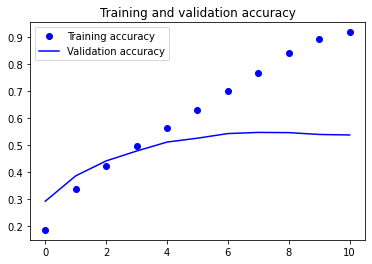

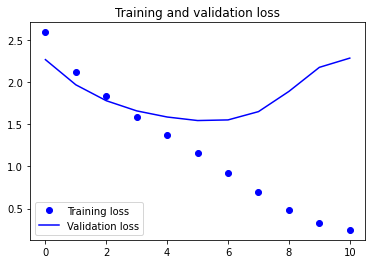

In [ ]:
plot_loss(conv_train)

##Implement model over original images without dropout with L2 regularization

In [ ]:
conv_net,conv_train=create_fit_model(batch_size=200,epochs=50,num_classes=20,train_data=x_train/255,
                                     train_label=y_onehot_train,l2=0.0005,dropout_plevel=0,
                                     loss_function=tf.keras.losses.CategoricalCrossentropy(),metric_function="accuracy",
                                     train_verbosity=1,stopping_patience=5)

Epoch 1/50
200/200 [==============================] - 31s 151ms/step - loss: 2.8696 - accuracy: 0.1473 - val_loss: 2.6312 - val_accuracy: 0.2007
Epoch 2/50
200/200 [==============================] - 30s 148ms/step - loss: 2.4985 - accuracy: 0.2419 - val_loss: 2.4450 - val_accuracy: 0.2653
Epoch 3/50
200/200 [==============================] - 30s 148ms/step - loss: 2.2961 - accuracy: 0.3142 - val_loss: 2.2429 - val_accuracy: 0.3325
Epoch 4/50
200/200 [==============================] - 30s 152ms/step - loss: 2.1624 - accuracy: 0.3618 - val_loss: 2.1098 - val_accuracy: 0.3806
Epoch 5/50
200/200 [==============================] - 29s 146ms/step - loss: 2.0488 - accuracy: 0.4028 - val_loss: 1.9978 - val_accuracy: 0.4218
Epoch 6/50
200/200 [==============================] - 29s 146ms/step - loss: 1.9521 - accuracy: 0.4377 - val_loss: 1.9404 - val_accuracy: 0.4426
Epoch 7/50
200/200 [==============================] - 28s 140ms/step - loss: 1.8575 - accuracy: 0.4744 - val_loss: 1.9630 - val_ac

In [ ]:
predicts_with_model(conv_net,x_test/255,y_test,dropout_plevel=0)

Accuracy over the test with normal dropout (P value:  0 ) set is:  0.5596
Accuracy over test set with MC dropout (P value:  0 ) set is: 0.5596
Average standard deviation of classification: 3.4376235e-08
Average standard deviation of misclassified samples: 2.870436e-08


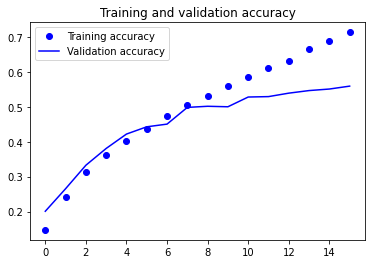

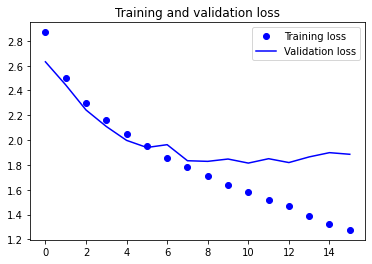

In [ ]:
plot_loss(conv_train)

#...with Dropout

##Implement model over normal images with dropout without regularization

In [ ]:
conv_net,conv_train=create_fit_model(batch_size=200,epochs=50,num_classes=20,train_data=x_train/255,
                                     train_label=y_onehot_train,l2=0,dropout_plevel=0.4,
                                     loss_function=tf.keras.losses.CategoricalCrossentropy(),metric_function="accuracy",
                                     train_verbosity=1,stopping_patience=20)

Epoch 1/50
200/200 [==============================] - 68s 193ms/step - loss: 2.7093 - accuracy: 0.1438 - val_loss: 2.5155 - val_accuracy: 0.2088
Epoch 2/50
200/200 [==============================] - 38s 189ms/step - loss: 2.3573 - accuracy: 0.2641 - val_loss: 2.2267 - val_accuracy: 0.3086
Epoch 3/50
200/200 [==============================] - 38s 190ms/step - loss: 2.1270 - accuracy: 0.3389 - val_loss: 2.0653 - val_accuracy: 0.3557
Epoch 4/50
200/200 [==============================] - 38s 191ms/step - loss: 1.9761 - accuracy: 0.3891 - val_loss: 1.9472 - val_accuracy: 0.3928
Epoch 5/50
200/200 [==============================] - 38s 190ms/step - loss: 1.8451 - accuracy: 0.4247 - val_loss: 1.8613 - val_accuracy: 0.4241
Epoch 6/50
200/200 [==============================] - 36s 180ms/step - loss: 1.7356 - accuracy: 0.4586 - val_loss: 1.8105 - val_accuracy: 0.4432
Epoch 7/50
200/200 [==============================] - 36s 180ms/step - loss: 1.6527 - accuracy: 0.4824 - val_loss: 1.7671 - val_ac

In [ ]:
predicts_with_model(conv_net,x_test/255,y_test,dropout_plevel=0.4)

Accuracy over the test with normal dropout (P value:  0.4 ) set is:  0.5314
Accuracy over test set with MC dropout (P value:  0.4 ) set is: 0.5986
Average standard deviation of classification: 0.19657652
Average standard deviation of misclassified samples: 0.23019193


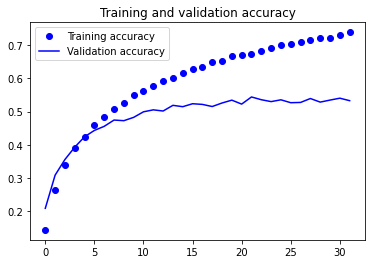

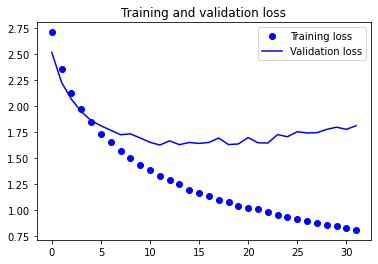

In [ ]:
plot_loss(conv_train)

##Implement model over augmented images with dropout without regularization

In [ ]:
conv_net,conv_train=create_fit_model(batch_size=200,epochs=50,num_classes=20,train_data=x_train_augmented,
                                     train_label=y_onehot_train,l2=0,dropout_plevel=0.4,
                                     loss_function=tf.keras.losses.CategoricalCrossentropy(),metric_function="accuracy",
                                     train_verbosity=1,stopping_patience=20)

Epoch 1/50
200/200 [==============================] - 38s 185ms/step - loss: 2.7702 - accuracy: 0.1261 - val_loss: 2.5858 - val_accuracy: 0.1887
Epoch 2/50
200/200 [==============================] - 36s 179ms/step - loss: 2.4255 - accuracy: 0.2386 - val_loss: 2.3277 - val_accuracy: 0.2695
Epoch 3/50
200/200 [==============================] - 38s 188ms/step - loss: 2.2239 - accuracy: 0.3063 - val_loss: 2.1715 - val_accuracy: 0.3217
Epoch 4/50
200/200 [==============================] - 38s 189ms/step - loss: 2.1035 - accuracy: 0.3426 - val_loss: 2.0671 - val_accuracy: 0.3586
Epoch 5/50
200/200 [==============================] - 38s 190ms/step - loss: 1.9934 - accuracy: 0.3780 - val_loss: 1.9787 - val_accuracy: 0.3894
Epoch 6/50
200/200 [==============================] - 34s 171ms/step - loss: 1.9135 - accuracy: 0.4047 - val_loss: 1.9990 - val_accuracy: 0.3891
Epoch 7/50
200/200 [==============================] - 36s 178ms/step - loss: 1.8373 - accuracy: 0.4247 - val_loss: 1.8952 - val_ac

In [ ]:
predicts_with_model(conv_net,x_test_augmented,y_test,dropout_plevel=0.4)

Accuracy over the test with normal dropout (P value:  0.4 ) set is:  0.4988
Accuracy over test set with MC dropout (P value:  0.4 ) set is: 0.5609
Average standard deviation of classification: 0.20051448
Average standard deviation of misclassified samples: 0.22505249


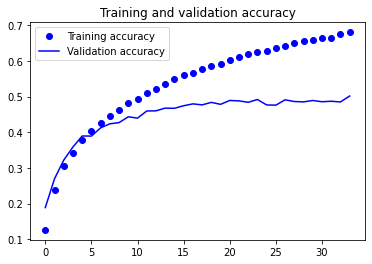

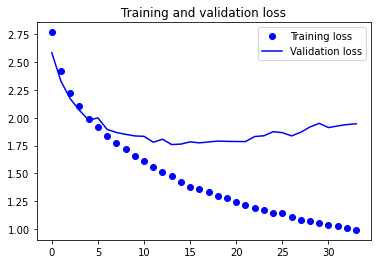

In [ ]:
plot_loss(conv_train)

##Implement model over original images with dropout with own regularization

In [ ]:
conv_net,conv_train=create_fit_model(batch_size=200,epochs=50,num_classes=20,train_data=x_train/255,
                                     train_label=modded_y,l2=0,dropout_plevel=0.4,
                                     loss_function=own_loss(Lambda=0.01),metric_function=accuracy,
                                     train_verbosity=1,stopping_patience=20)

Epoch 1/50
200/200 [==============================] - 38s 184ms/step - loss: 2.7199 - accuracy: 0.1449 - val_loss: 2.5144 - val_accuracy: 0.2128
Epoch 2/50
200/200 [==============================] - 37s 185ms/step - loss: 2.3607 - accuracy: 0.2599 - val_loss: 2.2478 - val_accuracy: 0.2986
Epoch 3/50
200/200 [==============================] - 38s 192ms/step - loss: 2.1671 - accuracy: 0.3273 - val_loss: 2.1362 - val_accuracy: 0.3378
Epoch 4/50
200/200 [==============================] - 39s 193ms/step - loss: 2.0223 - accuracy: 0.3738 - val_loss: 2.0153 - val_accuracy: 0.3808
Epoch 5/50
200/200 [==============================] - 36s 181ms/step - loss: 1.8877 - accuracy: 0.4121 - val_loss: 1.9957 - val_accuracy: 0.3770
Epoch 6/50
200/200 [==============================] - 38s 192ms/step - loss: 1.7918 - accuracy: 0.4408 - val_loss: 1.8446 - val_accuracy: 0.4256
Epoch 7/50
200/200 [==============================] - 36s 182ms/step - loss: 1.6922 - accuracy: 0.4725 - val_loss: 1.7827 - val_ac

In [ ]:
predicts_with_model(conv_net,x_test/255,y_test,dropout_plevel=0.4)

Accuracy over the test with normal dropout (P value:  0.4 ) set is:  0.5403
Accuracy over test set with MC dropout (P value:  0.4 ) set is: 0.6048
Average standard deviation of classification: 0.20438682
Average standard deviation of misclassified samples: 0.24253526


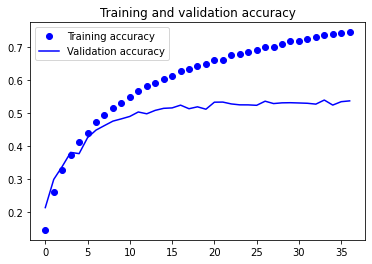

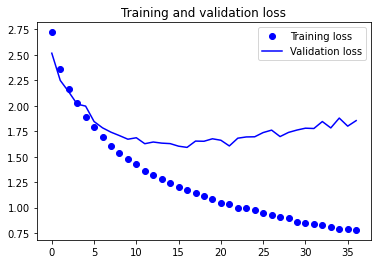

In [ ]:
plot_loss(conv_train)

##Implement model over original images with dropout with L2 regularization

In [ ]:
conv_net,conv_train=create_fit_model(batch_size=200,epochs=200,num_classes=20,train_data=x_train/255,
                                     train_label=y_onehot_train,l2=0.0005,dropout_plevel=0.4,
                                     loss_function=tf.keras.losses.CategoricalCrossentropy(),metric_function="accuracy",
                                     train_verbosity=1,stopping_patience=20)

Epoch 1/200
200/200 [==============================] - 38s 183ms/step - loss: 3.2565 - accuracy: 0.1080 - val_loss: 2.8372 - val_accuracy: 0.1672
Epoch 2/200
200/200 [==============================] - 38s 191ms/step - loss: 2.7142 - accuracy: 0.1981 - val_loss: 2.5990 - val_accuracy: 0.2243
Epoch 3/200
200/200 [==============================] - 38s 192ms/step - loss: 2.5245 - accuracy: 0.2524 - val_loss: 2.5261 - val_accuracy: 0.2605
Epoch 4/200
200/200 [==============================] - 38s 191ms/step - loss: 2.3854 - accuracy: 0.3004 - val_loss: 2.2972 - val_accuracy: 0.3212
Epoch 5/200
200/200 [==============================] - 37s 184ms/step - loss: 2.2712 - accuracy: 0.3378 - val_loss: 2.2590 - val_accuracy: 0.3424
Epoch 6/200
200/200 [==============================] - 38s 191ms/step - loss: 2.2026 - accuracy: 0.3590 - val_loss: 2.1952 - val_accuracy: 0.3646
Epoch 7/200
200/200 [==============================] - 38s 192ms/step - loss: 2.1332 - accuracy: 0.3852 - val_loss: 2.1351 -

In [ ]:
predicts_with_model(conv_net,x_test/255,y_test,dropout_plevel=0.4)

Accuracy over the test with normal dropout (P value:  0.4 ) set is:  0.5566
Accuracy over test set with MC dropout (P value:  0.4 ) set is: 0.6144
Average standard deviation of classification: 0.16412628
Average standard deviation of misclassified samples: 0.18728235


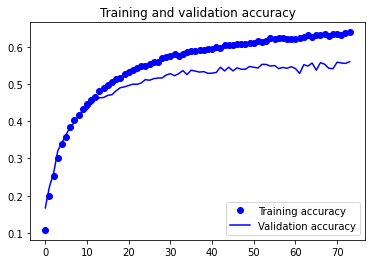

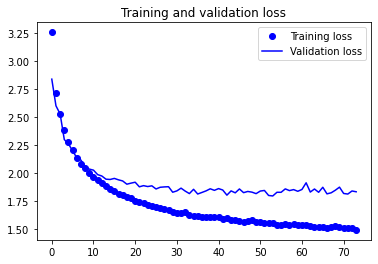

In [ ]:
plot_loss(conv_train)